# Preprocessing

## download data

In [1]:
import pandas as pd
from typing import *
from src.preprocess.dataset import Dataset, DatasetConfig
from src.preprocess.result import ResultData


# Usage Example:

dataset_names: Optional[List[str]]

result_data = ResultData(
    datadict = True, # Optional[Dict[str, pd.DataFrame]]
    ml_ready = True, # Optional[pd.DataFrame]
    metadata = True  # Optional["Metadata"]
    )

dataset = Dataset(DatasetConfig(
    type="raw"
))

result_data = dataset.get()


In [2]:
# dictionary with key=names : value=dataframe

"""
{"feature1" : dataframe}

frames in format:
year | country1 | country2 ...
2019 | value1   | value2   
"""

datadict : Dict[str, pd.DataFrame] = result_data.datadict

for key in list(datadict.keys()): 
    print(f"{key}") 

research_and_development_expenditure_percent_of_gdp
individuals_using_the_internet_percent_of_population
net_trade_in_goods_and_services_current_usd
fdi_net_inflows_current_usd
area
education_expenditures
education_years
services_value_added_percent_of_gdp
manufacturing_value_added_percent_of_gdp
net_official_development_assistance_received_current_usd
total_population
poverty_headcount_ratio_at_1.90_a_day_2011_ppp_percent_of_population
economic_activity
life_expectancy_at_birth_total_years
gdp_per_person_employed_constant_2011_ppp_usd
population_size
gini_income_inequality
petroleum_energy_production
renewables_excluding_hydro_share
energy_use_kg_of_oil_equivalent_per_capita
hydro_electric_energy_production
gas_energy_production
coal_energy_production
consumer_price_index_change
unemployment_rate_percent_of_total_labor_force
gdp_current_usd


In [3]:
from src.clean.health_check import health_check_datadict, print_health_anomalies

report = health_check_datadict(datadict)
print_health_anomalies(report)



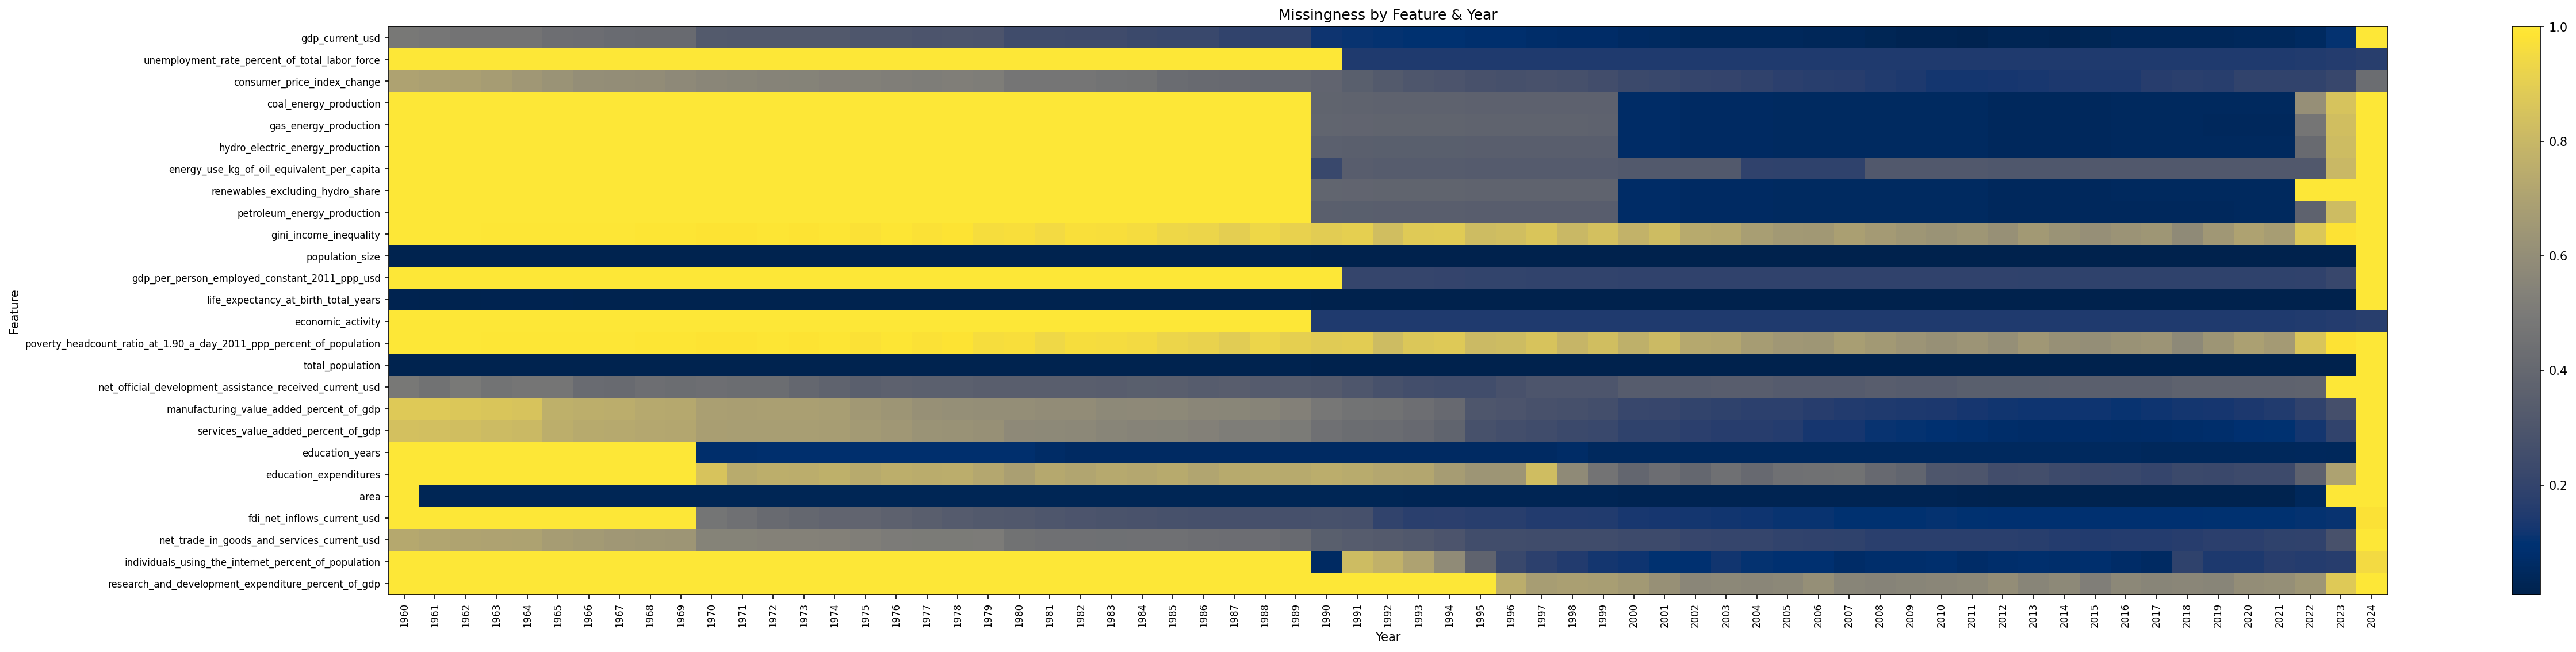

In [4]:
from src.clean.missing import compute_feature_yearly_missing, plot_feature_missing_heatmap

hm = compute_feature_yearly_missing(datadict)

plot_feature_missing_heatmap(hm)


In [5]:
print(datadict['research_and_development_expenditure_percent_of_gdp'].shape)

(65, 219)


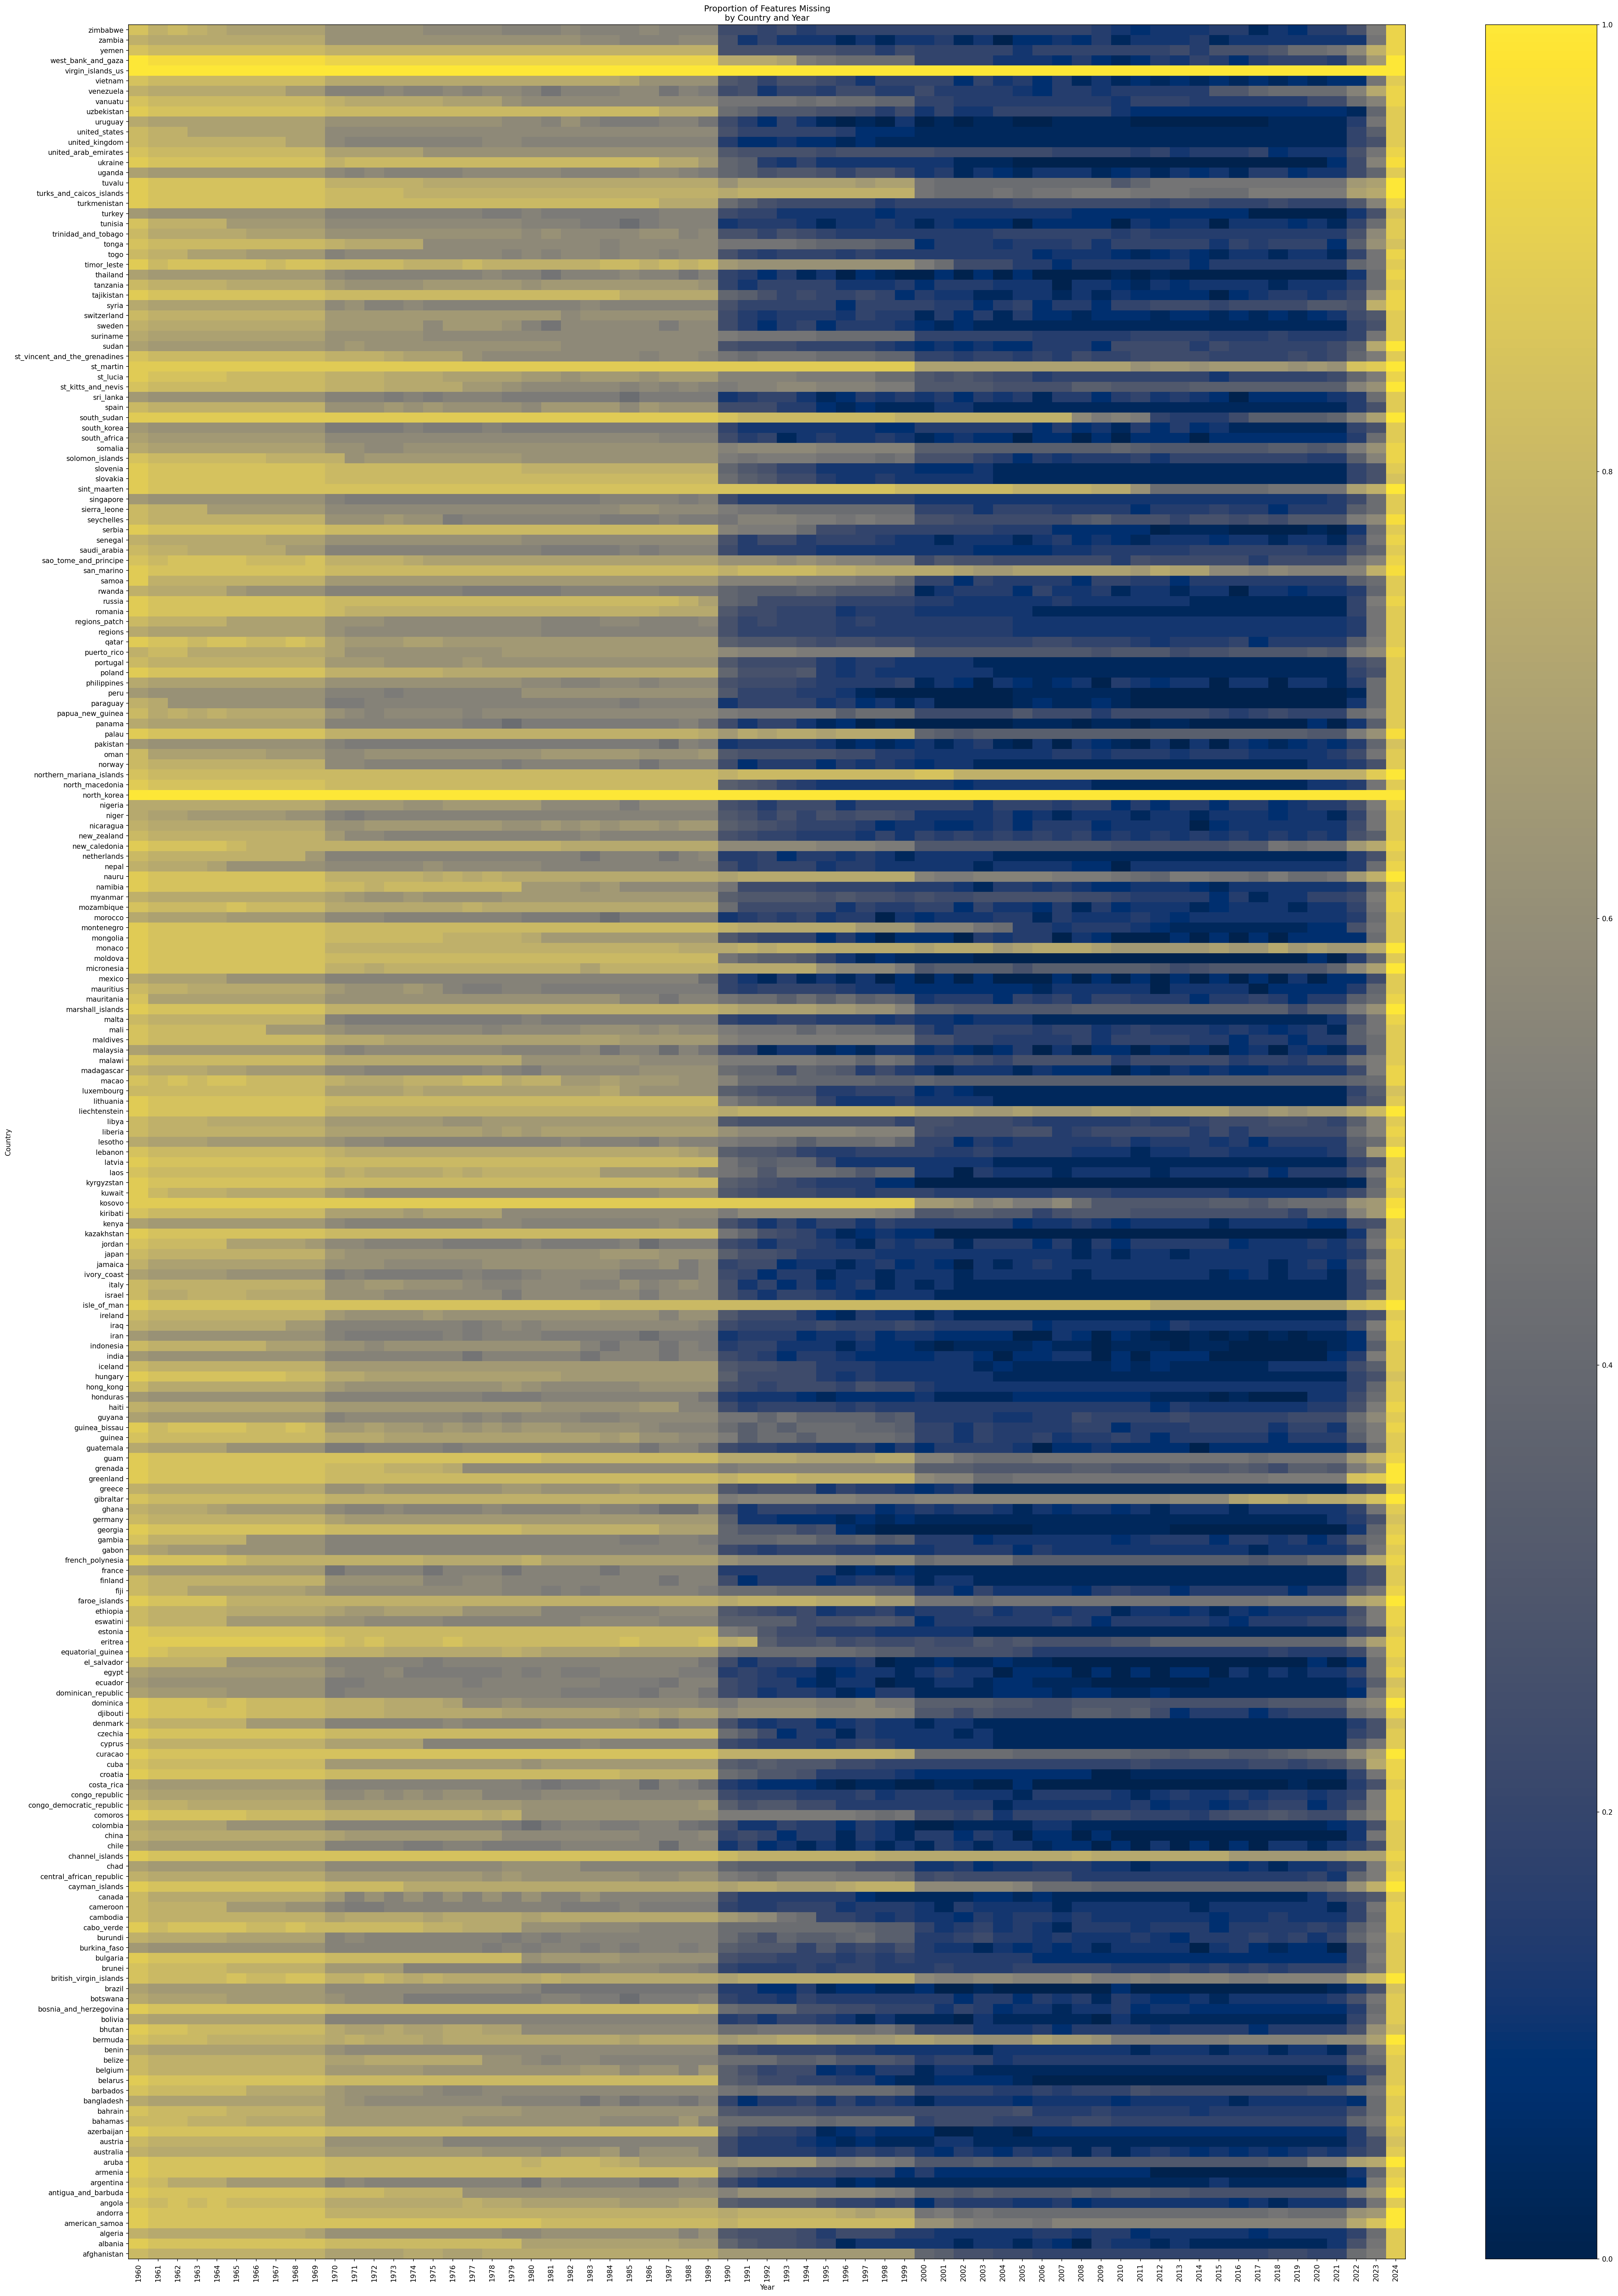

In [6]:

from src.clean.missing import compute_country_yearly_missing, plot_country_missing_heatmap

cty_hm = compute_country_yearly_missing(datadict)
plot_country_missing_heatmap(cty_hm)



In [7]:
ml = result_data.ml_ready

features = [c for c in ml.columns if c not in ("date", "country")]

na_per_feature = ml[features].isna().sum().sort_values(ascending=False)
print("Missing values per feature (all countries):")
print(na_per_feature.to_markdown(), "\n")

na_per_country = (
    ml
    .groupby("country")[features]
    .apply(lambda df: df.isna().sum().sum())
    .sort_values(ascending=False)
)
print("Missing values per country (all features):")
print(na_per_country.to_markdown())


Missing values per feature (all countries):
|                                                                      |     0 |
|:---------------------------------------------------------------------|------:|
| gini_income_inequality                                               | 12124 |
| poverty_headcount_ratio_at_1.90_a_day_2011_ppp_percent_of_population | 12040 |
| research_and_development_expenditure_percent_of_gdp                  | 11822 |
| energy_use_kg_of_oil_equivalent_per_capita                           |  9153 |
| education_expenditures                                               |  8959 |
| gdp_per_person_employed_constant_2011_ppp_usd                        |  8413 |
| renewables_excluding_hydro_share                                     |  8312 |
| individuals_using_the_internet_percent_of_population                 |  8199 |
| coal_energy_production                                               |  8174 |
| gas_energy_production                                          

In [8]:
filtered_dd = {
    name: df.loc[df.index.year > 1990]
    for name, df in datadict.items()
}

def drop_top_k_features_and_top_m_countries(
    data_dict: Dict[str, pd.DataFrame],
    k: int,
    m: int
) -> Dict[str, pd.DataFrame]:
    """
    From data_dict[name] = df (dates × countries), 
    1) drop the k indicator‐names with the largest overall NaN‐fraction,
    2) then drop the m country‐columns with the largest overall NaN‐fraction
       across the remaining DataFrames.
    """
    # 1) Compute NaN‐fraction per feature (averaged over all entries)
    nan_frac_feat = {
        name: df.isna().stack().mean()
        for name, df in data_dict.items()
    }
    # pick top-k worst
    drop_feats = sorted(nan_frac_feat, key=nan_frac_feat.get, reverse=True)[:k]
    filtered_feats = {
        name: df
        for name, df in data_dict.items()
        if name not in drop_feats
    }

    # 2) Compute NaN‐fraction per country across the remaining features
    #    (all DataFrames share the same full date‐index :contentReference[oaicite:0]{index=0}:contentReference[oaicite:1]{index=1})
    n_dates = next(iter(filtered_feats.values())).shape[0]
    n_feats = len(filtered_feats)
    # sum total NaNs for each country over all features
    country_nan_counts = {
        country: sum(df[country].isna().sum() for df in filtered_feats.values())
        for country in next(iter(filtered_feats.values())).columns
    }
    # total entries per country = n_dates * n_feats
    country_nan_frac = {
        c: cnt / (n_dates * n_feats)
        for c, cnt in country_nan_counts.items()
    }
    # pick top-m worst countries
    drop_countries = sorted(country_nan_frac, key=country_nan_frac.get, reverse=True)[:m]

    # 3) Drop those countries from every remaining DataFrame
    final_dict = {
        name: df.drop(columns=drop_countries)
        for name, df in filtered_feats.items()
    }

    return final_dict

cleaned_dd = drop_top_k_features_and_top_m_countries(filtered_dd, k=4, m=4)


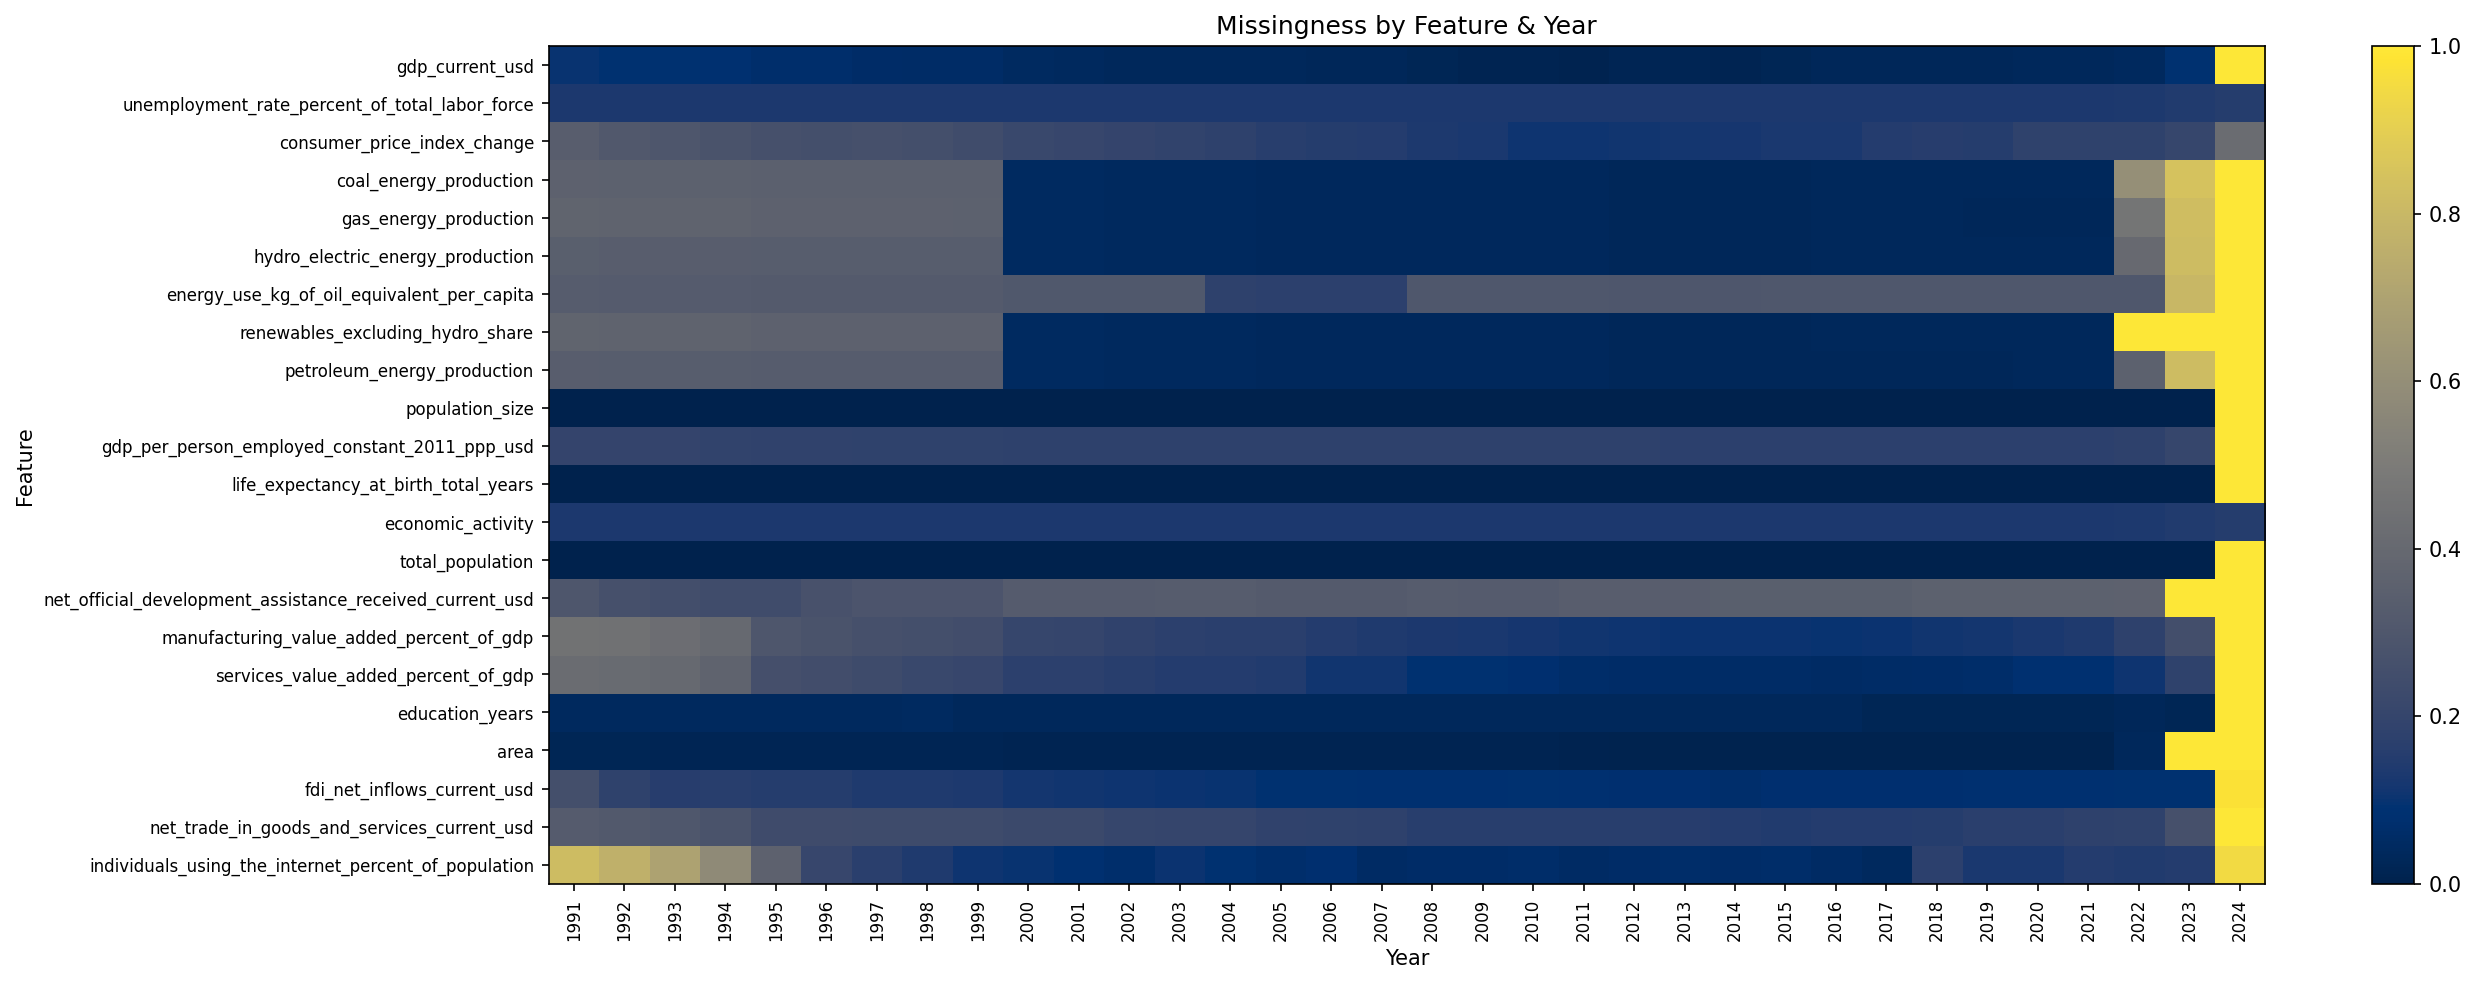

In [9]:
hm = compute_feature_yearly_missing(cleaned_dd)

plot_feature_missing_heatmap(hm)


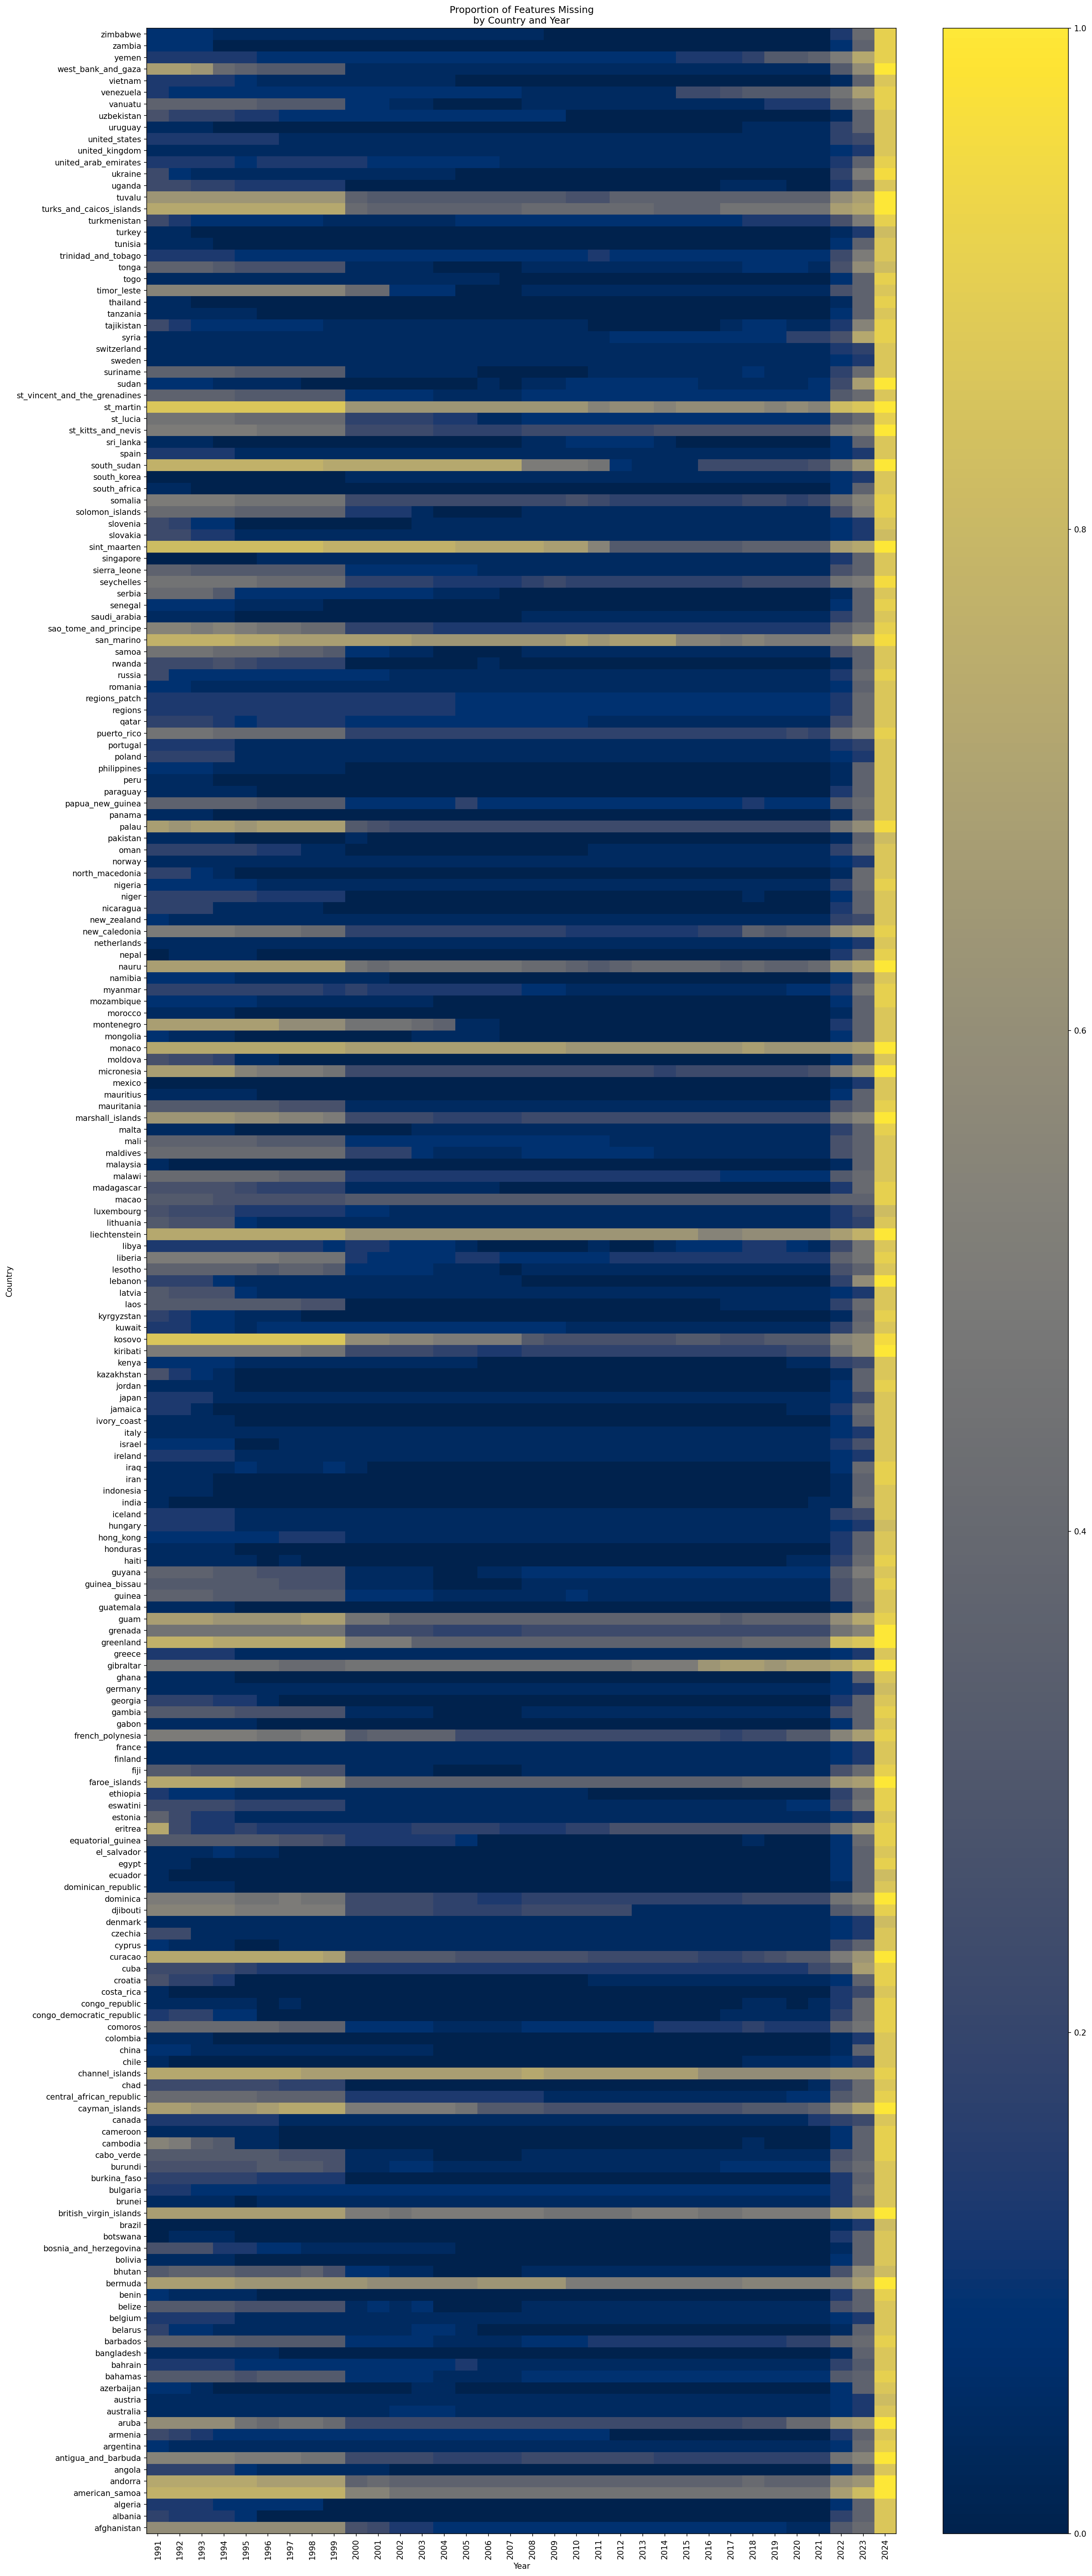

In [10]:
cty_hm = compute_country_yearly_missing(cleaned_dd)
plot_country_missing_heatmap(cty_hm)


In [11]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_imputation_dd(
    raw_dd: dict[str, pd.DataFrame],
    interp_dd: dict[str, pd.DataFrame],
    feature: str,
    country: str,
):
    """
    Diagnose one (country, feature) pair.

    • blue  •  = original observations
    • orange × = spline/linear interpolation (internal gap)
    • green ▲  = ffill / bfill (edge gap)
    """
    if feature not in raw_dd or feature not in interp_dd:
        raise KeyError(f"Feature {feature!r} not in datadict.")

    try:
        s_raw    = raw_dd   [feature][country].rename("raw").sort_index()
        s_interp = interp_dd[feature][country].rename("interp").sort_index()
    except KeyError:
        raise KeyError(f"{country!r} not found for {feature!r}.")

    # align on union of dates
    all_idx = s_raw.index.union(s_interp.index).sort_values()
    s_raw, s_interp = s_raw.reindex(all_idx), s_interp.reindex(all_idx)

    observed_mask = s_raw.notna()
    filled_mask   = s_raw.isna() & s_interp.notna()   # any kind of fill

    if observed_mask.any():
        first_obs = observed_mask.idxmax()
        last_obs  = observed_mask[::-1].idxmax()
    else:
        # degenerate case: no original data
        first_obs = last_obs = None

    pad_mask = filled_mask & (
        (all_idx < first_obs) | (all_idx > last_obs)
    )
    interp_mask = filled_mask & (~pad_mask)

    # ------------- plot -----------------
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(all_idx.year, s_interp, '-', color='lightgrey', zorder=0)

    ax.scatter(all_idx.year[observed_mask], s_interp[observed_mask],
               marker='o', label='original', s=30)
    ax.scatter(all_idx.year[interp_mask],   s_interp[interp_mask],
               marker='x', label='interpolated', s=50)
    ax.scatter(all_idx.year[pad_mask],      s_interp[pad_mask],
               marker='^', label='ffill / bfill', s=40)

    ax.set_title(f'{country} – {feature}')
    ax.set_xlabel('Year')
    ax.set_ylabel(feature)
    ax.legend()
    plt.tight_layout()
    plt.show()



['fdi_net_inflows_current_usd', 'area', 'education_years', 'services_value_added_percent_of_gdp', 'total_population', 'economic_activity', 'life_expectancy_at_birth_total_years', 'population_size', 'petroleum_energy_production', 'hydro_electric_energy_production', 'unemployment_rate_percent_of_total_labor_force', 'gdp_current_usd']
Index(['ivory_coast', 'united_kingdom', 'russia', 'slovakia', 'syria',
       'vietnam', 'united_states', 'regions', 'ecuador', 'egypt',
       ...
       'china', 'colombia', 'comoros', 'congo_democratic_republic',
       'congo_republic', 'costa_rica', 'croatia', 'cyprus', 'czechia',
       'denmark'],
      dtype='object', length=182)


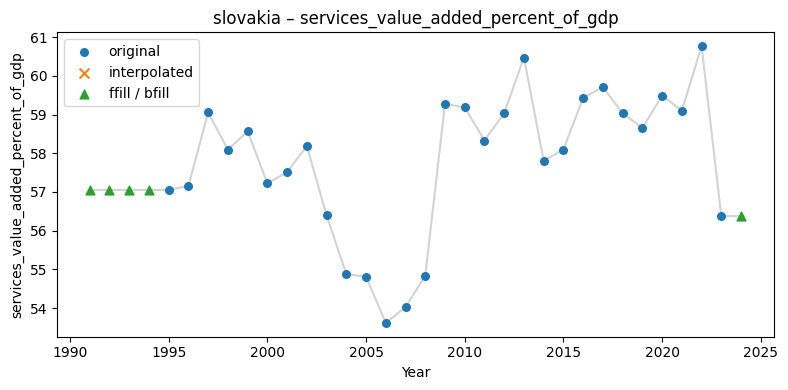

In [12]:
# 1) Load raw & cleaned ml_ready tables

# 1) load the two datadicts
filter_dd = Dataset(DatasetConfig(type="filter")).get(
               datadict=True, metadata=False).datadict
clean_dd  = Dataset(DatasetConfig(type="clean" )).get(
               datadict=True, metadata=False).datadict

print(list(filter_dd.keys()))
print(filter_dd[list(filter_dd.keys())[0]].columns)

# 2) plot
plot_imputation_dd(
    raw_dd    = filter_dd,
    interp_dd = clean_dd,
    feature   = 'services_value_added_percent_of_gdp',
    country   = 'slovakia'
)
